# Explainable Reinforcement Learning for Longitudinal Control

### Demonstration using the example of the LongiControl Environment

https://www.researchgate.net/publication/349113191_Explainable_Reinforcement_Learning_for_Longitudinal_Control

This notebook demonstrates how to use SHAP for explaining Reinforcement Learning Agents. Here, we are explaining the DDPG actor network from an agent trained on the LongiControl Environment.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import gym
from rl.ddpg.DDPG_tf1 import DDPG
import shap
import warnings
warnings.filterwarnings('ignore') 

### Initialise LongiControl Environment

In [2]:
env = gym.make('gym_longicontrol:StochasticTrack-v0')

### Initialise DDPG

In [3]:
ddpg = DDPG(a_dim=1, s_dim=8, a_bound=1)

### Load trained DDPG agent

In [4]:
best_saver = tf.train.Saver().restore(ddpg.sess,'./checkpoints/model_DDPG_02.ckpt-600')

### DRL Agent – Testing

In [5]:
# python function to get the state_log and action_log
def eval(mode=0, video=False, speed_limits=[50, 120, 40, 50]):
    #action_log = np.array([])
    action_log = []
    #state_log = np.array([])
    state_log = []
    
    if mode==0:
        env = gym.make('gym_longicontrol:StochasticTrack-v0')
    else:
        env = gym.make('gym_longicontrol:DeterministicTrack-v0', speed_limits=speed_limits)
    if video==True:
        env = wrappers.Monitor(env, './videos/' + str(time()) + '/')
    s = env.reset()
    done = False
    reward = 0
    while not(done):
        if video:
            env.render()
        a = ddpg.choose_action(np.array([s]))
        s_, r, done, info = env.step(a)
        s = s_
        reward +=r
        
        action_log.append(a)
        state_log.append(s)
        #if len(state_log)==0:
        #    state_log = np.expand_dims(s, axis=0)
        #else:
        #    state_log = np.append(state_log, np.expand_dims(s, axis=0), axis=0)
    
    return np.array(state_log), np.array(action_log)

In [6]:
# Lets the agent drive a random or stochastic track and passes on the states and actions that occurred
state_log, action_log = eval(mode=1)

In [10]:
# Define the names of the states
feature_names=['velocity\nin m/s', 'prev_acceleration\nin $\mathregular{m/s^2}$', 'current_speed_limit \n in m/s', 'future_speed_limit\n_velocity_1 in m/s', 'future_speed_limit\n_velocity_2 in m/s', 'future_speed_limit\n_distance_1 in m', 'future_speed_limit\n_distance_2 in m','energy_factor']

### RL-SHAP Diagram

In [11]:
def explain(ddpg=ddpg, state_log=state_log, feature_names=feature_names, action_log=action_log, cmap='coolwarm', save_fig=False):

    # Build explainer
    model = ([ddpg.S], ddpg.a) # define inputs and outputs of actor
    explainer = shap.DeepExplainer(model, state_log, session=ddpg.sess) # build DeepExplainer
    shap_values = explainer.shap_values(state_log) # Calculate shap values
       
    state_log_re = state_log*(env.state_max - env.state_min) + env.state_min # rescale state log 
    
    norm = plt.Normalize(vmin=-1, vmax=1) # define color scala between -1 and +1 (like the agents action space)  
        
    fig = plt.figure(figsize=(15,12))
    gs = fig.add_gridspec(9, hspace=0)
    axs = gs.subplots(sharex=True, sharey=False)
    axs[0].plot(state_log_re[:,0])
    axs[0].plot(state_log_re[:,2])
    axs[0].set_ylabel('velocity\nin m/s')
    axs[0].legend(['vehicle', 'speed limit'])
    axs[1].scatter(range(0, len(action_log)), action_log, c=action_log-explainer.expected_value, cmap = cmap, norm=norm)
    axs[1].set_ylabel('action')
    axs[1].yaxis.set_label_position('right')
    axs[2].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,0], c=shap_values[0][:,0], cmap=cmap, norm=norm)
    axs[2].set_ylabel(feature_names[0])
    axs[3].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,1], c=shap_values[0][:,1], cmap=cmap, norm=norm)
    axs[3].set_ylabel(feature_names[1])
    axs[3].yaxis.set_label_position('right')
    axs[4].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,2], c=shap_values[0][:,2], cmap=cmap, norm=norm)
    axs[4].set_ylabel(feature_names[2])
    axs[5].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,3], c=shap_values[0][:,3], cmap=cmap, norm=norm)
    axs[5].set_ylabel(feature_names[3])   
    axs[5].yaxis.set_label_position('right')
    axs[6].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,5], c=shap_values[0][:,5], cmap=cmap, norm=norm)
    axs[6].set_ylabel(feature_names[5])    
    axs[7].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,4], c=shap_values[0][:,4], cmap=cmap, norm=norm)
    axs[7].set_ylabel(feature_names[4])   
    axs[7].yaxis.set_label_position('right')
    axs[8].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,6], c=shap_values[0][:,6], cmap=cmap, norm=norm)
    axs[8].set_ylabel(feature_names[6])    
    axs[8].set_xlabel('Distance in m')
    
    if save_fig:
        fig.savefig("Shap_RL_Example.pdf", bbox_inches='tight')

    

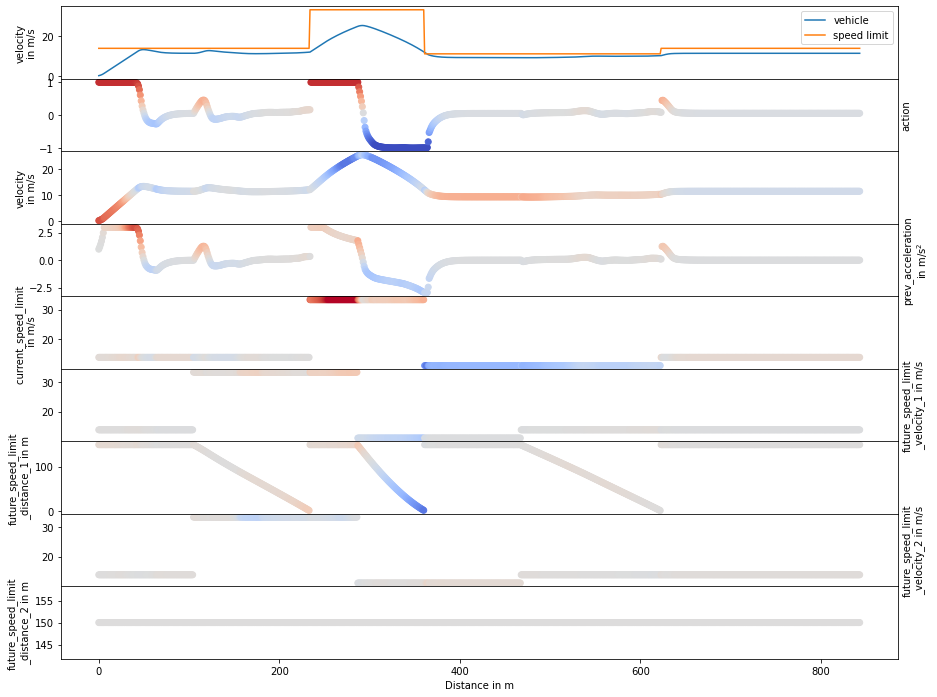

In [12]:
# output with shap values
explain(ddpg, state_log, feature_names, action_log)